In [1]:
import numpy as np
import pandas as pd
import torch
from collections import defaultdict

In [2]:
# Products, departments and aisles
product_df = pd.read_csv("./data/products.csv")
aisles_df = pd.read_csv("./data/aisles.csv")
deparments_df = pd.read_csv("./data/departments.csv")
products_df = product_df.merge(deparments_df, on="department_id", how="left")
products_df = products_df.merge(aisles_df, on="aisle_id", how="left")

# Order informations
dist_store_df = pd.read_csv("./data/orders_distance_stores_softmax.csv")
dist_store_df = dist_store_df.drop("Unnamed: 0", axis=1)
prod_prior_df = pd.read_csv("./data/order_products__prior_specials.csv")
prod_prior_df = prod_prior_df.drop("Unnamed: 0", axis=1)
merged_df = prod_prior_df.merge(dist_store_df, on="order_id")

basic_info_df = pd.DataFrame([
    ["orders_distance_stores_softmax", dist_store_df.shape[0], dist_store_df.shape[1]],
    ["order_products_prior_specials", prod_prior_df.shape[0], prod_prior_df.shape[1]],
    ["merged", merged_df.shape[0], merged_df.shape[1]]
    ],
    columns=["File", "# Instances", "# Attributes"]
)
basic_info_df.head(10)

,File,# Instances,# Attributes
0,orders_distance_stores_softmax,136026,9
1,order_products_prior_specials,1172312,5
2,merged,1172312,13


In [3]:
# Columns with unique values
uniq_cols = list(merged_df.columns[merged_df.nunique() == 1])

# Columns with invalid values
nan_cols = list(merged_df.columns[merged_df.isna().any()])

print("Unique columns: {}".format(uniq_cols))
print("NaN columns: {}".format(nan_cols))

# NaN values days_since_prior_order come from items bought twice on the same day.
# Replace the values with with zeros
merged_df["days_since_prior_order"] = merged_df["days_since_prior_order"].fillna(0)
# Remove columns with unique values
merged_df = merged_df.drop(uniq_cols, axis=1)

assert len(list(merged_df.columns[merged_df.nunique() == 1])) == 0, "There are still columns with unique values"
assert len(list(merged_df.columns[merged_df.isna().any()])) == 0, "There are still columns with NaN values"

Unique columns: ['eval_set']
NaN columns: ['days_since_prior_order']


In [5]:
# Merge product information with orders
full_df = merged_df.merge(products_df, on="product_id", how="left")
full_df.head(5)

n_products = full_df["product_id"].nunique()
n_stores = full_df["store_id"].nunique()
n_users = full_df["user_id"].nunique()
n_departments = full_df["department_id"].nunique()
n_aisles = full_df["aisle_id"].nunique()
n_orders = full_df["order_id"].nunique()
n_target_rows = int(len(merged_df) * 0.05)

print("Target number of rows: %d" % n_target_rows)
print("Current number of rows: %d" % len(full_df))
print("Number of rows to remove: %d" % (len(full_df) - n_target_rows))
basic_info_df = pd.DataFrame(
    [[n_products, n_departments, n_aisles, n_stores, n_users, n_orders]],
    columns=["# Products", "# Departments", "# Aisles", "# Stores", "# Users", "# Orders"]
)
basic_info_df

Target number of rows: 58615
Current number of rows: 1172312
Number of rows to remove: 1113697


,# Products,# Departments,# Aisles,# Stores,# Users,# Orders
0,24860,21,134,10,1374,136026


1    907879
0    264433
Name: reordered, dtype: int64
1    0.774435
0    0.225565
Name: reordered, dtype: float64


<AxesSubplot:>

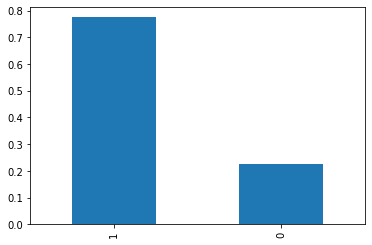

In [30]:
# Distribution des classes
print((merged_df["reordered"].value_counts() / len(merged_df)))
(merged_df["reordered"].value_counts() / len(merged_df)).plot.bar()

On constate un débalancement assez sévère des classes. On compte 907 879 (77.4435%) et 264 433 (22.5565%) commandes avec respectivement "reordered=True" et "reordered=False". Autrement dit, les commandes avec produits achetés à plusieurs reprises sont 3.43 fois plus nombreux que les produits nouveaux. Notre sous-échantillonage doit donc prendre en compte ce débalancement pour éviter de perdre trop d'instances "reordered=False".

In [9]:
merged_df[['user_id', 'order_id']].groupby(['user_id', 'order_id']).size()

user_id  order_id
210      12659       23
         27316       38
         46152       31
         90696       23
         110472      13
                     ..
206105   3224249      2
         3262881      4
         3263743      4
         3276477      6
         3367002      2
Length: 136026, dtype: int64

Commençons par supprimer les instances aberrantes, c'est-à-dire:
- les clients avec peu de commandes différentes;
- les produits achetés par peu de clients différents;
- les produits présents dans peu de commandes différentes;

In [10]:
# Fonction utilitaire permettant de simuler une requête d'aggrégation SQL du genre
# SELECT col, COUNT(DISTINCT agg_col) AS n_agg_col FROM table_name GROUP BY col, agg_col
# Les commandes équivalentes avec l'API de Pandas génèrent beaucoup de doublons, ce qui nous force
# à implémenter cette solution.  
def count_distinct(dataframe, groupby_col, count_col):
    d = defaultdict()
    for row in dataframe.itertuples():
        uid = getattr(row, groupby_col)
        d[uid] = set()

    for row in dataframe.itertuples():
        uid = getattr(row, groupby_col)
        count_attr = getattr(row, count_col)
        d[uid].add(count_attr)

    df_count_col_name = "%s_count" % count_col
    d = {groupby_col: d.keys(), df_count_col_name: [len(v) for v in d.values()]}
    return pd.DataFrame.from_dict(d).sort_values(by=df_count_col_name)

In [24]:
users_n_order_df = count_distinct(merged_df, "user_id", "order_id")
print(users_n_order_df)

products_n_order_df = count_distinct(merged_df, "product_id", "order_id")
print(products_n_order_df)

      user_id  order_id_count
0       54901              99
920     71049              99
919    159610              99
918    190212              99
917     19612              99
...       ...             ...
454    150481              99
453    170217              99
452     31606              99
460     96192              99
1373    85247              99

[1374 rows x 2 columns]
       product_id  order_id_count
24859       17633               1
21220       36348               1
21221       19574               1
21223       29096               1
21224       33586               1
...           ...             ...
123         21903            9594
126         47209           10654
27          21137           13163
62          24852           16466
37          13176           17652

[24860 rows x 2 columns]


Le premier tableau nous informe que les données sont organisées de sorte que chaque utilisateur a exactement 99 commandes. Par conséquent, aucun consommateur ne doit être retiré. Cependant, plusieurs produits sont présents dans 1 commande. Nous devons donc les retirer.

In [39]:
order_id_cnt_thres = products_n_order_df["order_id_count"].quantile(0.5)
n_products = products_n_order_df["product_id"].nunique()
mask = products_n_order_df["order_id_count"] < order_id_cnt_thres
to_remove = products_n_order_df[mask]["product_id"].unique()

print("Number of products: %d" % n_products)
print("Number products to remove: %d" % len(to_remove))
print("Number of remaining products: %d" % (n_products - len(to_remove)))

n_rows_before = len(merged_df)
mask = merged_df["product_id"].isin(to_remove)
merged_df_prime = merged_df.drop(merged_df[mask].index)
n_rows_after = len(merged_df_prime)

print("Num rows to remove: %d\nNum remaining rows: %d" % (mask.sum(), n_rows_after))

Number of products: 24860
Number products to remove: 11983
Number of remaining products: 12877
Num rows to remove: 26086
Num remaining rows: 1146226


In [40]:
products_n_users_df = count_distinct(merged_df_prime, "product_id", "user_id")
products_n_users_df

,product_id,user_id_count
3873,41906,1
12197,43794,1
6986,40344,1
9124,9796,1
11092,48139,1
...,...,...
60,24852,739
117,21903,741
120,47209,775
36,13176,907


In [41]:
user_id_cnt_thres = products_n_users_df["user_id_count"].quantile(0.25)
mask = products_n_users_df["user_id_count"] < thres
to_remove = products_n_users_df[mask]["product_id"].unique()

print("Number of products: %d" % n_products)
print("Number products to remove: %d" % len(to_remove))
print("Number of remaining products: %d" % (n_products - len(to_remove)))

n_rows_before = len(merged_df_prime)
mask = merged_df["product_id"].isin(to_remove)
merged_df_prime = merged_df_prime.drop(merged_df_prime[mask].index)
n_rows_after = len(merged_df_prime)
print("Num rows to remove: %d\nNum remaining rows: %d" % (mask.sum(), n_rows_after))

Number of products: 24860
Number products to remove: 2740
Number of remaining products: 22120
Num rows to remove: 37587
Num remaining rows: 1108639


C:\Users\verdi\AppData\Local\Temp\ipykernel_12248\599373950.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  merged_df_prime = merged_df_prime.drop(merged_df_prime[mask].index)


On s'assure que les modifications respectent les conditions, c'est-à-dire
- les consommateurs ont plusieurs commandes ;
- les produits sont présents dans plusieurs commandes;
- les produits sont achetés par plusieurs consommateurs;

In [42]:
# Validation
users_n_order_df = count_distinct(merged_df_prime, "user_id", "order_id")
assert users_n_order_df["order_id_count"].min() >= order_id_cnt_thres, "Il reste des utilisateurs avec moins de %d commandes différentes." % order_id_cnt_thres

products_n_order_df = count_distinct(merged_df_prime, "product_id", "order_id")
assert products_n_order_df["order_id_count"].min() > user_id_cnt_thres, "Il reste des produits présents dans moins de %d commandes différentes." % user_id_cnt_thres

products_n_order_df = count_distinct(merged_df_prime, "product_id", "user_id")
assert products_n_order_df["user_id_count"].min() > 1, "Il reste des produits achetés seulement par un consommateur"

In [61]:
class_ratio_df = merged_df_prime["reordered"].value_counts() / len(merged_df_prime)
maj_cls_ratio = class_ratio_df[1]
min_cls_ratio = class_ratio_df[0]
class_ratio_df

1    0.78371
0    0.21629
Name: reordered, dtype: float64

Après toutes ces opérations, il reste 1 108 639 lignes, ce qui représente environ 5% des données originales. Il reste donc 1 050 023 entrées à supprimer. Pour ce faire, nous proposons la stratégie suivante. On conserve d'abord toutes les instances de la classes minoritaires. On les ordonne ensuite en fonction du nombre de commandes par utilisateur. Finalement, on ajoute une instance originale par utilisateur de la liste obtenue de manière itérative jusqu'à ce que le nombre de lignes souhaitées (5% des données originales) soit obtenu.

Stratégie alternative: puisque nous avons un nombre de commandes élevées pour chacun des utilisateurs, on peut simplement conserver au plus $\tau = n\_lignes\_disponibles / n\_clients$  commandes différentes pour chacun des utilisateurs.

In [54]:
tau = int(n_target_rows / users_n_order_df["user_id"].nunique())
assert users_n_order_df["order_id_count"].min() > tau, "Il existe un ou plusieurs clients avec un nombre de commandes inférieur à %d." % tau
tau

42

Comme tous les clients possèdent au minimum 42 commandes, cette stratégie devrait fonctionner. On doit être prudent et conserver un ratio des classes similaire dans notre procédure. Avec la loi forte des grands nombres, on sait qu'un sous-échantillonage aléatoire devrait conserver le ratio original. Toutefois, pour nous en assurer, nous introduisons une procédure de type Las Vegas qui répète le sous-échantillonage jusqu'à ce le ratio soit respecté à un epsilon près. 

In [ ]:
ratio_is_respected = False
while not ratio_is_respected:
    ratio_is_respected

In [ ]:
from collections import deque

user_queue = deque(users_n_order_df["user_id"].values)

keepinmind = r1[""]
n_rows = 0
while n_rows < n_target_rows:
    cur_uid = user_queue.popleft()

user_queue
# final_data = []
# for tup in t1.itertuples():
#     cur_uid = tup.user_id
#     print(tup.user_id)
#     break

In [44]:
users_n_order_df

,user_id,order_id_count
1200,117101,67
1231,151840,79
895,182854,81
1372,4284,81
483,127547,81
...,...,...
509,59604,99
508,62772,99
506,120840,99
514,184451,99


In [43]:
import duckdb 
t1 = duckdb.query("select user_id, count(order_id) AS n_orders from merged_df group by user_id, order_id").df().sort_values(by="n_orders")
t1

,user_id,n_orders
59387,26489,1
95957,110851,1
79318,49159,1
95955,195449,1
36574,198709,1
...,...,...
89651,201268,92
10877,201268,92
78732,201268,94
15168,201268,98


In [6]:
# Retirer les consommateurs avec peu de commandes
users_to_remove = t1[(t1["n_orders"] < 4)]["user_id"].unique()
t1 = t1.drop(t1[t1["n_orders"] < 4].index)
subset_df = merged_df.drop(merged_df[merged_df["user_id"].isin(users_to_remove)].index)
n_users = subset_df["user_id"].nunique()
print("Removing {} users helped reduce the number of orders by {}".format(len(users_to_remove), len(merged_df) - len(subset_df)))
subset_df

Removing 1314 users helped reduce the number of orders by 1080355


,order_id,product_id,add_to_cart_order,reordered,special,user_id,store_id,distance,order_number,order_dow,order_hour_of_day,days_since_prior_order
44,185,23165,1,1,0,172793,8,0.677334,72,3,1,2.0
45,185,24964,2,1,0,172793,8,0.677334,72,3,1,2.0
46,185,39812,3,0,30,172793,8,0.677334,72,3,1,2.0
47,185,11520,4,0,50,172793,8,0.677334,72,3,1,2.0
48,185,41556,5,0,15,172793,8,0.677334,72,3,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1172128,3420383,46820,11,1,15,173431,6,1.321906,14,1,15,5.0
1172129,3420383,24830,12,0,15,173431,6,1.321906,14,1,15,5.0
1172130,3420383,11507,13,0,30,173431,6,1.321906,14,1,15,5.0
1172131,3420383,42768,14,0,15,173431,6,1.321906,14,1,15,5.0


In [7]:
# select products that were bought by different customers
p = {uid: {"cnt": 0, "users": set()} for uid in subset_df["product_id"].values}
 
for _, line in subset_df.iterrows():
    p_uid = int(line["product_id"])
    p[p_uid]["cnt"] += 1
    p[p_uid]["users"].add(int(line["user_id"]))

for uid, prod in p.items():
    p[uid]["users"] = len(p[uid]["users"])

data_matrix = [[uid, *p[uid].values()] for uid in p.keys()]

t3 = pd.DataFrame(data_matrix, columns=["product_id", "count", "n_users"])
t3

,product_id,count,n_users
0,23165,37,10
1,24964,611,32
2,39812,79,17
3,11520,84,6
4,41556,12,6
...,...,...,...
6113,31564,1,1
6114,15975,1,1
6115,32478,1,1
6116,48415,1,1


In [8]:
#products_to_remove = t3[(t3["n_users"] / n_users < 0.001)]["product_id"]
products_to_remove = t3[(t3["n_users"] / t3["n_users"].sum()) < 0.0001]["product_id"]
n_deleted_products = len(products_to_remove)
subset_df_prime = subset_df.drop(subset_df[subset_df["product_id"].isin(products_to_remove)].index)
print("Removing {} products helped to remove {} orders".format(n_deleted_products, len(subset_df) - len(subset_df_prime)))
subset_df_prime

Removing 3629 products helped to remove 15534 orders


,order_id,product_id,add_to_cart_order,reordered,special,user_id,store_id,distance,order_number,order_dow,order_hour_of_day,days_since_prior_order
44,185,23165,1,1,0,172793,8,0.677334,72,3,1,2.0
45,185,24964,2,1,0,172793,8,0.677334,72,3,1,2.0
46,185,39812,3,0,30,172793,8,0.677334,72,3,1,2.0
47,185,11520,4,0,50,172793,8,0.677334,72,3,1,2.0
48,185,41556,5,0,15,172793,8,0.677334,72,3,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1172126,3420383,36076,9,1,0,173431,6,1.321906,14,1,15,5.0
1172128,3420383,46820,11,1,15,173431,6,1.321906,14,1,15,5.0
1172129,3420383,24830,12,0,15,173431,6,1.321906,14,1,15,5.0
1172131,3420383,42768,14,0,15,173431,6,1.321906,14,1,15,5.0


In [19]:
t1 = duckdb.query("select user_id, count(order_id) AS n_orders from subset_df_prime group by user_id, order_id").df().sort_values(by="n_orders")
users_to_drop = t1[(t1["n_orders"] <= 1)]["user_id"].unique()
subset_df_prime = subset_df_prime.drop(subset_df_prime[subset_df_prime["user_id"].isin(users_to_drop)].index)
subset_df_prime

,order_id,product_id,add_to_cart_order,reordered,special,user_id,store_id,distance,order_number,order_dow,order_hour_of_day,days_since_prior_order
44,185,23165,1,1,0,172793,8,0.677334,72,3,1,2.0
45,185,24964,2,1,0,172793,8,0.677334,72,3,1,2.0
46,185,39812,3,0,30,172793,8,0.677334,72,3,1,2.0
47,185,11520,4,0,50,172793,8,0.677334,72,3,1,2.0
48,185,41556,5,0,15,172793,8,0.677334,72,3,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1172126,3420383,36076,9,1,0,173431,6,1.321906,14,1,15,5.0
1172128,3420383,46820,11,1,15,173431,6,1.321906,14,1,15,5.0
1172129,3420383,24830,12,0,15,173431,6,1.321906,14,1,15,5.0
1172131,3420383,42768,14,0,15,173431,6,1.321906,14,1,15,5.0


In [27]:
from collections import deque
t1 = duckdb.query("select user_id, count(order_id) AS n_orders from subset_df_prime group by user_id, order_id").df().sort_values(by="n_orders")
user_queue = deque(t1["user_id"].values)

keepinmind = r1[""]
n_rows = 0
while n_rows < n_target_rows:
    cur_uid = user_queue.popleft()

user_queue
# final_data = []
# for tup in t1.itertuples():
#     cur_uid = tup.user_id
#     print(tup.user_id)
#     break

deque([10934,
       185080,
       102339,
       54804,
       185080,
       4693,
       89064,
       95338,
       102339,
       102339,
       47666,
       69995,
       102339,
       95338,
       50087,
       10934,
       95338,
       10934,
       69995,
       10934,
       69995,
       178107,
       99727,
       166786,
       47666,
       99727,
       173431,
       69995,
       69995,
       157548,
       53684,
       54804,
       53684,
       10934,
       102339,
       185080,
       95338,
       113588,
       102339,
       10934,
       178107,
       95338,
       204455,
       102339,
       204455,
       121860,
       181970,
       47666,
       69995,
       102339,
       47666,
       121860,
       181970,
       102339,
       165294,
       113588,
       181970,
       69995,
       4693,
       121860,
       131093,
       185080,
       95338,
       178107,
       4693,
       10934,
       132022,
       172793,
       10934,
    

In [ ]:
# Rebalancer le nombre de commandes par client
removed_rows = len(merged_df) - len(subset_df)
n_target_rows = int(len(merged_df) * 0.05)
to_remove = len(subset_df) - n_target_rows
print("removed: {}\ntarget: {}\nto remove: {}".format(removed_rows, n_target_rows, to_remove))
thres = int(n_target_rows / n_users)
# People under the threshold must be kept
# Therefore the sum of their orders removed from the number of rows
mask = t1["n_orders"] <= thres
to_keep = mask.sum()
users_prime = t1[mask]["user_id"].unique()
pool_size = to_remove - to_keep
# This means customers with more than thres orders must share pool_size rows 
pool_size
(t1["n_orders"] <= thres).sum() == 136026
to_keep
#n_target_rows / 1370
#n_target_rows
#t1["n_orders"].describe()

In [ ]:
merged_df[["product_id", "user_id"]].groupby("user_id").size().max() #apply(lambda x: list(x["product_id"]))
# n_products_per_user = merged_df[["product_id", "user_id"]].groupby("product_id").size()

# n_products_per_orders /= n_products_per_orders.sum()
#n_products_per_user.describe()

In [ ]:
# Order products by their priors
products_priors = test_df["product_id"].value_counts() / test_df["product_id"].value_counts().sum()
np.testing.assert_almost_equal(products_priors.sum(), 1.)
products_priors

In [ ]:
# Products with strong priors actually come from the same department
test_df[test_df["product_id"].isin(products_priors[0:5].index)][["product_name", "department", "aisle"]]

In [ ]:
department_priors = test_df[["department", "department_id"]].value_counts() / test_df["department"].value_counts().sum()
np.testing.assert_almost_equal(department_priors.sum(), 1.)
department_priors

In [ ]:
ds = {uid: {"priors": pct, "products": {}, "name": ""} for uid, pct in department_id_priors.to_dict().items()}
for department_id in ds.keys():
    mask = test_df["department_id"] == department_id
    ds[department_id]["name"] = test_df[mask]["department"].unique()[0]
    #product_ids = list(test_df["department_id" == department_id]["product_id"])
ds

In [ ]:
test_df[mask]["department"].unique()[0]

In [ ]:
# https://stackoverflow.com/questions/18138693/replicating-group-concat-for-pandas-dataframe
P = np.zeros((n_products, n_products))
order_prod_grouped_df = merged_df.groupby("order_id").apply(lambda x: list(x["product_id"]))

In [ ]:
for line in order_prod_grouped_df:
    for product in line:
        for other_product in line:
            P[product-1, other_product-1] += 1

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(P)
pca.explained_variance_ratio_


In [ ]:
order_prod_grouped_df